In [135]:
#imports
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import env
import acquire, prepare
import requests as req
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

### Acquire 

In [136]:
#acquire github data on repos referencing 470 cyber security repositories
# scrape = acquire.scrape_github_data()

In [137]:
# len(scrape)

In [138]:
# df = pd.DataFrame(scrape)
# df

In [139]:
# data = df.to_csv('repo_readmes.csv')
df = pd.read_csv('repo_readmes.csv', usecols=['repo','language','readme_contents'])

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             470 non-null    object
 1   language         305 non-null    object
 2   readme_contents  395 non-null    object
dtypes: object(3)
memory usage: 11.1+ KB


### Prepare

In [141]:
df = df[df.language.notnull()]
df = df[df.readme_contents.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 5 to 469
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             254 non-null    object
 1   language         254 non-null    object
 2   readme_contents  254 non-null    object
dtypes: object(3)
memory usage: 7.9+ KB


In [147]:
# Dropped languages with only 1 observation
# Dropped 165 nulls in language
languages = df.value_counts('language')
languages = pd.DataFrame(languages)
languages

,0
language,
Python,80
Jupyter Notebook,36
HTML,26
Java,19
Shell,17
JavaScript,14
CSS,11
C,6
C++,6


In [143]:
#limit dataframe to the top 6 languages
top_6_languages = df.language.value_counts().index[0:6]

In [10]:
df = df[df.language.isin(top_6_languages)]
df

,repo,language,readme_contents
5,DerekBabb/CyberSecurity,Java,# Cyber Security\n### A curriculum for a high ...
7,PacktPublishing/Machine-Learning-for-Cybersecu...,Jupyter Notebook,# Machine Learning for Cybersecurity Cookbook ...
8,llSourcell/Build-a-Cybersecurity-Startup,JavaScript,# Overview\n\nThis is the code for [this](http...
15,scusec/Data-Mining-for-Cybersecurity,HTML,# Data-Mining-for-Cybersecurity\n\n本项目主要是课程《Da...
16,guidesmiths/cybersecurity-handbook,JavaScript,# Cybersecurity handbook\n\n![Cover image](pub...
...,...,...,...
461,jonathan6661/P1sty,Python,"# P1sty\n\n<p align=""center"">\n<img src=""https..."
464,Patrowl/PatrowlHears,Python,![](https://github.com/Patrowl/PatrowlDocs/blo...
466,tropicoo/zoneh,Python,# zoneh\nZone-H cybercrime archive monitoring ...
467,diogo-fernan/domfind,Python,# *domfind*\n\n*domfind* is a Python 3.6.x uti...


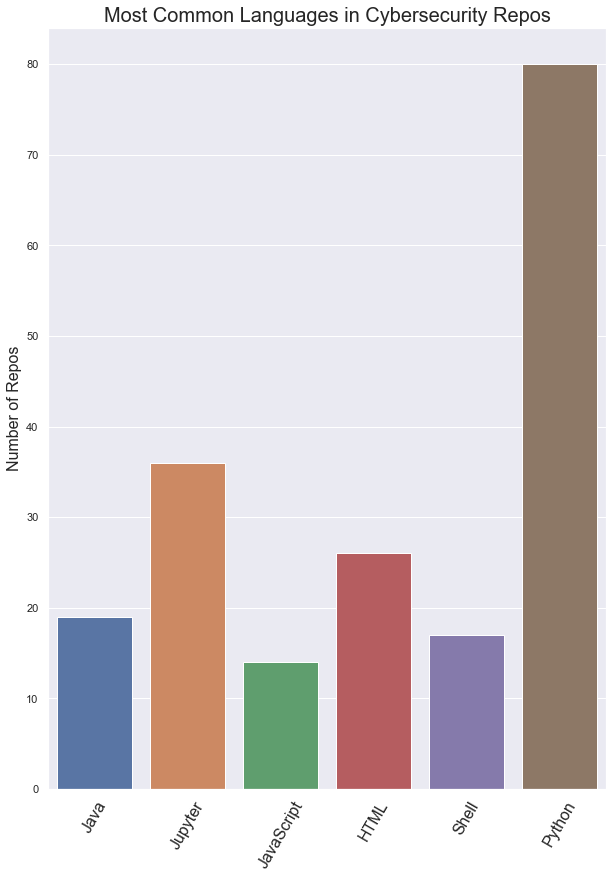

In [96]:
#create count plot for top 6 languages
%matplotlib inline
plt.figure(figsize=(10, 14))
sns.set(style="darkgrid")
ax = sns.countplot(x=df.language)
plt.title('Most Common Languages in Cybersecurity Repos', fontsize = 20)
plt.xlabel(None)
plt.ylabel('Number of Repos', fontsize = 16)
plt.xticks([0, 1, 2, 3, 4, 5], ['Java','Jupyter', 'JavaScript', 'HTML', 'Shell', 'Python'])
plt.xticks(rotation = 60, fontsize = 16)
plt.savefig('cybersecurity.png')
plt.show()

#### Takeaways
- Python is the most commonly used
- followed by Jupyter Notebook, HTML, Java, Shell, JavaScript


### Preparing the Data
- Clean, Normalize, Tokenize, Lemmatize
- Created six sets of data to capture words used in repositories for my top 6 languages: python, jupyter notebook, html, java, shell and jscript

In [12]:
# # prepare the data by applying the clean function
# df.readme_contents = df.readme_contents.apply(prepare.clean)
# df

In [13]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

In [14]:
#clean to hold the normalized and tokenized original with the stopwords removed.
df['clean'] = df['readme_contents'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))
#stemmed to hold the stemmed version of the cleaned data.
df['stemmed'] = df['clean'].apply(lambda x: prepare.stem(x))
#lemmatized to hold the lemmatized version of the cleaned data.
df['lemmatized'] = df['clean'].apply(lambda x: prepare.lemmatize(x))
df

,repo,language,readme_contents,clean,stemmed,lemmatized
5,DerekBabb/CyberSecurity,Java,# Cyber Security\n### A curriculum for a high ...,cyber security curriculum high school cyber se...,cyber secur curriculum high school cyber secur...,cyber security curriculum high school cyber se...
7,PacktPublishing/Machine-Learning-for-Cybersecu...,Jupyter Notebook,# Machine Learning for Cybersecurity Cookbook ...,machine learning cybersecurity cookbook hrefht...,machin learn cybersecur cookbook hrefhttpswwwp...,machine learning cybersecurity cookbook hrefht...
8,llSourcell/Build-a-Cybersecurity-Startup,JavaScript,# Overview\n\nThis is the code for [this](http...,overview code thishttpsyoutubebxw8vqxxvqc vide...,overview code thishttpsyoutubebxw8vqxxvqc vide...,overview code thishttpsyoutubebxw8vqxxvqc vide...
15,scusec/Data-Mining-for-Cybersecurity,HTML,# Data-Mining-for-Cybersecurity\n\n本项目主要是课程《Da...,dataminingforcybersecurity data mining cyberse...,dataminingforcybersecur data mine cybersecur 2...,dataminingforcybersecurity data mining cyberse...
16,guidesmiths/cybersecurity-handbook,JavaScript,# Cybersecurity handbook\n\n![Cover image](pub...,cybersecurity handbook cover imagepubliccoverj...,cybersecur handbook cover imagepubliccoverjpg ...,cybersecurity handbook cover imagepubliccoverj...
...,...,...,...,...,...,...
461,jonathan6661/P1sty,Python,"# P1sty\n\n<p align=""center"">\n<img src=""https...",p1sty p aligncenter img srchttpsuserimagesgith...,p1sti p aligncent img srchttpsuserimagesgithub...,p1sty p aligncenter img srchttpsuserimagesgith...
464,Patrowl/PatrowlHears,Python,![](https://github.com/Patrowl/PatrowlDocs/blo...,httpsgithubcompatrowlpatrowldocsblobmasterimag...,httpsgithubcompatrowlpatrowldocsblobmasterimag...,httpsgithubcompatrowlpatrowldocsblobmasterimag...
466,tropicoo/zoneh,Python,# zoneh\nZone-H cybercrime archive monitoring ...,zoneh zoneh cybercrime archive monitoring tele...,zoneh zoneh cybercrim archiv monitor telegram ...,zoneh zoneh cybercrime archive monitoring tele...
467,diogo-fernan/domfind,Python,# *domfind*\n\n*domfind* is a Python 3.6.x uti...,domfind domfind python 36x utility tests exist...,domfind domfind python 36x util test exist dom...,domfind domfind python 36x utility test existe...


In [15]:
#use clean function to create six sets of data: Python, Jupyter Notebook, HTML, Java, Shell, JavaScript and CSS and rejoin lemmatized words to one string
python_words = clean(' '.join(df.lemmatized[df.language == 'Python']))
jupyter_words = clean(' '.join(df.lemmatized[df.language == 'Jupyter Notebook']))
html_words = clean(' '.join(df.lemmatized[df.language == 'HTML']))
java_words = clean(' '.join(df.lemmatized[df.language == 'Java']))
shell_words = clean(' '.join(df.lemmatized[df.language == 'Shell']))
jscript_words = clean(' '.join(df.lemmatized[df.language == 'JavaScript']))


### Explore

In [16]:
#finding most common bigrams in python words
top_10_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(10))

top_10_python_bigrams

(pip, install)          20
(cyber, security)       13
(git, clone)            12
(domain, name)          12
(aptget, install)       11
(9, 9)                  10
(python, managepy)       9
(sophos, central)        9
(r, requirementstxt)     8
(run, python)            7
dtype: int64

In [17]:
#finding most common bigrams in jupyter words
top_10_jupyter_bigrams = (pd.Series(nltk.ngrams(jupyter_words, 2))
                      .value_counts()
                      .head(10))

top_10_jupyter_bigrams

(machine, learning)           37
(jupyter, notebook)           16
(window, mac)                 16
(x, linux)                    16
(o, x)                        16
(mac, o)                      16
(learning, cybersecurity)     12
(deteccion, de)               11
(conjunto, de)                 9
(artificial, intelligence)     8
dtype: int64

In [18]:
#finding most common bigrams in html words
top_10_html_bigrams = (pd.Series(nltk.ngrams(html_words, 2))
                      .value_counts()
                      .head(10))

top_10_html_bigrams

(9, 9)                      9
(social, engineering)       8
(capture, flag)             7
(ip, address)               5
(attack, social)            5
(flag, ctf)                 5
(assignment, submission)    5
(assignment, capture)       4
(domestic, violence)        4
(course, course)            4
dtype: int64

In [19]:
#finding most common bigrams in java words
top_10_java_bigrams = (pd.Series(nltk.ngrams(java_words, 2))
                      .value_counts()
                      .head(10))

top_10_java_bigrams

(cyber, security)       28
(step, reproduce)       21
(reproduce, 1)          16
(username, password)    12
(1, open)               11
(high, school)          10
(admin, page)           10
(suggested, fix)         8
(open, browser)          7
(browser, go)            7
dtype: int64

In [20]:
#finding most common bigrams in shell words
top_10_shell_bigrams = (pd.Series(nltk.ngrams(shell_words, 2))
                      .value_counts()
                      .head(10))

top_10_shell_bigrams

(elk, server)           8
(container, running)    8
(running, dvwa)         7
(host, container)       6
(br, download)          6
(physical, system)      5
(window, host)          5
(docker, container)     5
(public, license)       5
(general, public)       5
dtype: int64

In [21]:
#finding most common bigrams in jscript words
top_10_jscript_bigrams = (pd.Series(nltk.ngrams(jscript_words, 2))
                      .value_counts()
                      .head(10))

top_10_jscript_bigrams

(sulla, blockchain)    17
(che, ci)              16
(styleborder, 0h3a)    15
(td, styleborder)      15
(git, clone)           11
(npm, install)         11
(che, si)               9
(di, esecuzione)        9
(ad, effettuare)        9
(il, comando)           9
dtype: int64

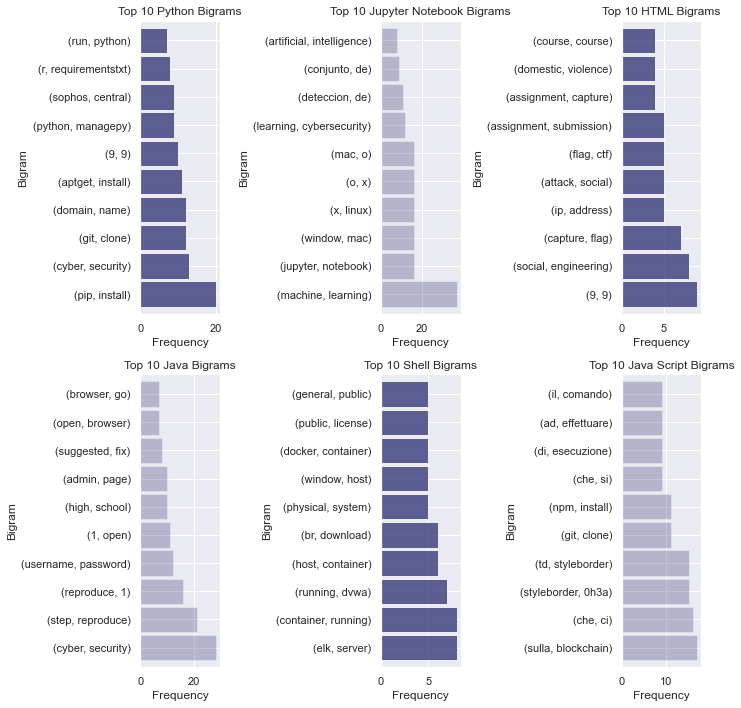

In [148]:
#Create bar plots comparing top 10 bigrams for top 6 languages
plt.subplot(231)
top_10_python_bigrams.plot.barh(width=.9, figsize=(10, 10), alpha=.8, colormap='tab20b')
plt.title('Top 10 Python Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(232)
top_10_jupyter_bigrams.plot.barh(colormap='tab20b', width=.9, figsize=(10, 10), alpha=.3)
plt.title('Top 10 Jupyter Notebook Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(233)
top_10_html_bigrams.plot.barh(colormap='tab20b', width=.9, figsize=(10, 10), alpha=.8)
plt.title('Top 10 HTML Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(234)
top_10_java_bigrams.plot.barh(colormap='tab20b', width=.9, figsize=(10, 10), alpha=.3)
plt.title('Top 10 Java Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(235)
top_10_shell_bigrams.plot.barh(colormap='tab20b', width=.9, figsize=(10, 10), alpha=.8)
plt.title('Top 10 Shell Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(236)
top_10_jscript_bigrams.plot.barh(colormap='tab20b', width=.9, figsize=(10, 10), alpha=.3)
plt.title('Top 10 Java Script Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')


plt.tight_layout()
plt.savefig('bar_bigrams.png')
plt.show()

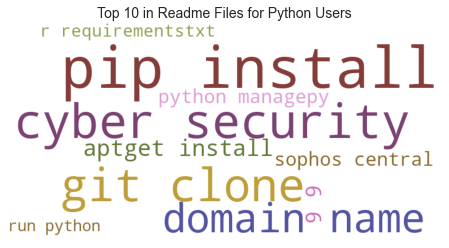

In [125]:
# Create word cloud of top 10 bigrams in Python
data = {k[0] + ' ' + k[1]: v for k, v in top_10_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, colormap='tab20b').generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 10 in Readme Files for Python Users', fontsize = 14)
plt.savefig('pythonbigrams.png')
plt.show()

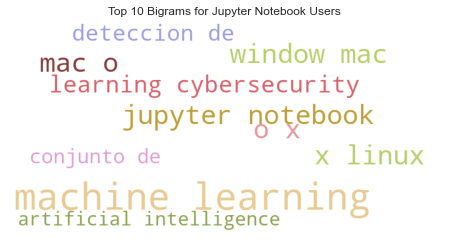

In [117]:
# Create word cloud of top 10 bigrams in Jupyter Notebook
data = {k[0] + ' ' + k[1]: v for k, v in top_10_jupyter_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, colormap='tab20b').generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 10 Bigrams for Jupyter Notebook Users')
plt.savefig('pythonbigrams.png')
plt.show()

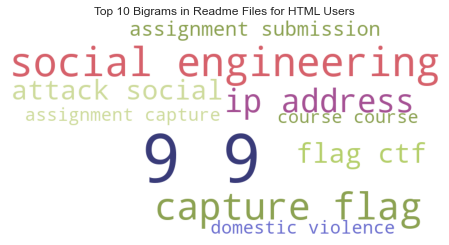

In [103]:
# Create word cloud of top 10 bigrams in HTML
data = {k[0] + ' ' + k[1]: v for k, v in top_10_html_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, colormap='tab20b').generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 10 Bigrams in Readme Files for HTML Users')
plt.show()

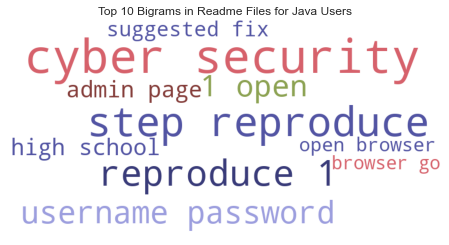

In [26]:
# Create word cloud of top 10 bigrams in Java
data = {k[0] + ' ' + k[1]: v for k, v in top_10_java_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, colormap='tab20b').generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 10 Bigrams in Readme Files for Java Users')
plt.show()

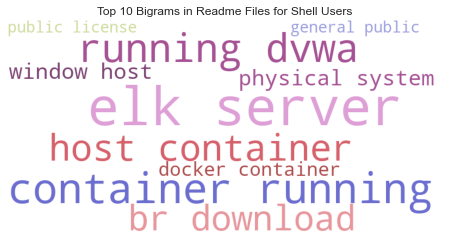

In [27]:
# Create word cloud of top 10 bigrams in shell
data = {k[0] + ' ' + k[1]: v for k, v in top_10_shell_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, colormap='tab20b').generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 10 Bigrams in Readme Files for Shell Users')
plt.show()

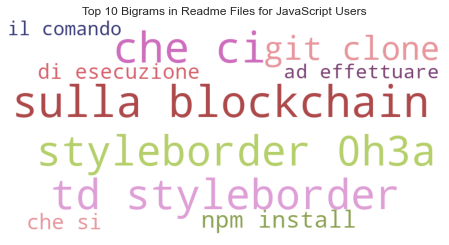

In [28]:
# Create word cloud of top 10 bigrams in Java Script
data = {k[0] + ' ' + k[1]: v for k, v in top_10_jscript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, colormap='tab20b').generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 10 Bigrams in Readme Files for JavaScript Users')
plt.show()

### Establish baseline for modeling

In [29]:
baseline = pd.DataFrame(df.language)
baseline['baseline'] = 'Python'

In [30]:
baseline

,language,baseline
5,Java,Python
7,Jupyter Notebook,Python
8,JavaScript,Python
15,HTML,Python
16,JavaScript,Python
...,...,...
461,Python,Python
464,Python,Python
466,Python,Python
467,Python,Python


### Baseline accuracy is 42%

In [31]:
# Baselinebaseline accuracy
baseline_accuracy = round((baseline.language == baseline.baseline).mean(),2)
baseline_accuracy

0.42

### Split Data

In [32]:
# Split the data for modeling
train, validate, test = prepare.split(df, 'language')
train.shape, validate.shape, test.shape

((107, 6), (46, 6), (39, 6))

In [33]:
# setup X-train, validate and test variables
X_train = train.lemmatized
X_validate = validate.lemmatized
X_test = test.lemmatized

# setup y-train, validate and test variables
y_train = train.language
y_validate = validate.language
y_test = test.language

In [34]:
X_train.shape, X_validate.shape, X_test.shape

((107,), (46,), (39,))

In [35]:
y_train.shape, y_validate.shape, y_test.shape

((107,), (46,), (39,))

### Vectorizing data before classification modeling
- converting text to numerical representations

In [36]:
# Create the tfidf vectorizer object
# Step 1: create tf-idf value for each word, for each lemmatized readme
# Step 2: encode these values for use on models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

### Logistic Regression

In [37]:
# Create logistic regression object -- to use on vectorized data
lm = LogisticRegression()

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)



LogisticRegression()

In [38]:
#create dataframes of actual values
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [39]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

In [40]:
# Train Accuracy
train_accuracy = round((train.actual == train.predicted).mean(),2)
train_accuracy

0.68

In [41]:
# Validate Accuracy
validate_accuracy = round((validate.actual == validate.predicted).mean(),2)
validate_accuracy

0.52

In [42]:
#begin building a dataframe to record accuracy
metric_df = pd.DataFrame(data=[{
    'model': 'logistic regression', 
    'baseline_accuracy': round(baseline_accuracy,2),
    'train_accuracy': round(train_accuracy, 2),
    'validate_accuracy': round(validate_accuracy, 2)}])
metric_df

,model,baseline_accuracy,train_accuracy,validate_accuracy
0,logistic regression,0.42,0.68,0.52


### Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


#Create the model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [44]:
#Fit the model
rf.fit(X_train_vectorized, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [45]:
#Check feature importance
print(rf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [46]:
#Make predictions
y_train_pred = rf.predict(X_train_vectorized)
y_validate_pred = rf.predict(X_validate_vectorized)

In [47]:
#Estimate the probability
y_train_pred_proba = rf.predict_proba(X_train_vectorized)
y_validate_pred_proba = rf.predict_proba(X_validate_vectorized)

In [48]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train_vectorized, y_train)))

Accuracy of random forest classifier on training set: 0.42


In [49]:
rf_train_accuracy = round(rf.score(X_train_vectorized, y_train),2)

In [50]:
print(confusion_matrix(y_train, y_train_pred))

[[ 0  0  0  0 15  0]
 [ 0  0  0  0 10  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0 45  0]
 [ 0  0  0  0  9  0]]


In [51]:
print(classification_report(y_train, y_train_pred))

                  precision    recall  f1-score   support

            HTML       0.00      0.00      0.00        15
            Java       0.00      0.00      0.00        10
      JavaScript       0.00      0.00      0.00         8
Jupyter Notebook       0.00      0.00      0.00        20
          Python       0.42      1.00      0.59        45
           Shell       0.00      0.00      0.00         9

        accuracy                           0.42       107
       macro avg       0.07      0.17      0.10       107
    weighted avg       0.18      0.42      0.25       107



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
### Less precision than Logistic Regression -- will not run on test!
#Check accuracy on validate
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate_vectorized, y_validate)))

Accuracy of random forest classifier on validate set: 0.41


In [53]:
rf_validate_accuracy = round(rf.score(X_validate_vectorized, y_validate),2)

In [54]:
#append dataframe to compare accuracy
metric_df = metric_df.append({
    'model': 'random_forest', 
    'baseline_accuracy': baseline_accuracy,
    'train_accuracy': rf_train_accuracy,
    'validate_accuracy': rf_validate_accuracy}, ignore_index=True)
metric_df


,model,baseline_accuracy,train_accuracy,validate_accuracy
0,logistic regression,0.42,0.68,0.52
1,random_forest,0.42,0.42,0.41


### K-Nearest Neighbor

In [55]:
#imports 
from sklearn.neighbors import KNeighborsClassifier

In [56]:
# Create the object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [57]:
#Fit the model
knn.fit(X_train_vectorized, y_train)

KNeighborsClassifier()

In [58]:
#Make predictions
y_train_pred = knn.predict(X_train_vectorized)

In [59]:
#Estimate probability
y_train_pred_proba = knn.predict_proba(X_train_vectorized)

In [60]:
#Evaluate on accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train_vectorized, y_train)))

Accuracy of KNN classifier on training set: 0.63


In [61]:
knn_train_accuracy = knn.score(X_train_vectorized, y_train)
knn_train_accuracy

0.6261682242990654

In [62]:
#Make predictions
y_validate_pred = knn.predict(X_validate_vectorized)

In [63]:
#Estimate probability
y_validate_pred_proba = knn.predict_proba(X_validate_vectorized)

In [64]:
#Evaluate on accuracy
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate_vectorized, y_validate)))

Accuracy of KNN classifier on validate set: 0.43


In [65]:
knn_validate_accuracy = round(knn.score(X_validate_vectorized, y_validate),2)
knn_validate_accuracy

0.43

In [66]:
#append dataframe to compare accuracy
metric_df = metric_df.append({
    'model': 'K-Nearest Neighbor', 
    'baseline_accuracy': baseline_accuracy,
    'train_accuracy': round(knn_train_accuracy,2),
    'validate_accuracy': knn_validate_accuracy}, ignore_index=True)
metric_df


,model,baseline_accuracy,train_accuracy,validate_accuracy
0,logistic regression,0.42,0.68,0.52
1,random_forest,0.42,0.42,0.41
2,K-Nearest Neighbor,0.42,0.63,0.43


### Model on test data

In [67]:
#Make predictions
y_test_pred = knn.predict(X_test_vectorized)

In [68]:
#Estimate probability
y_test_pred_proba = knn.predict_proba(X_test_vectorized)

In [69]:
#Evaluate on accuracy
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test_vectorized, y_test)))

Accuracy of KNN classifier on test set: 0.49


In [70]:
knn_test_accuracy = knn.score(X_test_vectorized, y_test)
knn_test_accuracy

0.48717948717948717

In [71]:
# CLASSIFICATION REPORT ON TEST

print('Accuracy: {:.2%}'.format(knn_test_accuracy))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(y_test_pred, y_test))
# print('---')
cm = pd.DataFrame(pd.crosstab(y_test_pred, y_test))
cm

report = classification_report(y_test, y_test_pred, output_dict=True, zero_division = 0)

Accuracy: 48.72%
---


In [131]:
report = pd.DataFrame(report).transpose()
report

,HTML,Java,JavaScript,Jupyter Notebook,Python,Shell,accuracy,macro avg,weighted avg
precision,0.333333,0.5,0.0,0.666667,0.480000,0.0,0.487179,0.330000,0.410598
recall,0.200000,0.5,0.0,0.571429,0.750000,0.0,0.487179,0.336905,0.487179
f1-score,0.250000,0.5,0.0,0.615385,0.585366,0.0,0.487179,0.325125,0.433937
support,5.000000,4.0,3.0,7.000000,16.000000,4.0,0.487179,39.000000,39.000000


### K-Nearest Neighbor Model:
- K-Nearest Neighbor on Test:  Accuracy of 49% 
- Baseline Accuracy: 42%
- Train Accuracy: 63%
- Validate Accuracy: 43%
- Test Accuracy:  49%


### Writing a Prediction Function

In [73]:
def pred_language(text):
    '''
    This function takes in a README file and predicts the 
    programming language most prevalent in the repository.
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

    #clean to hold the normalized and tokenized original with the stopwords removed.
    df['clean'] = df['readme_contents'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))
    #stemmed to hold the stemmed version of the cleaned data.
    df['stemmed'] = df['clean'].apply(lambda x: prepare.stem(x))
    #lemmatized to hold the lemmatized version of the cleaned data.
    df['lemmatized'] = df['clean'].apply(lambda x: prepare.lemmatize(x))
   